# Factor Recovery by Block PCA

Under suitable conditions factor models are identifiable via PCA. This notebook explores whether is possible to recover loadings, factors, and common components in a static factor model by performing blockwise-PCA. The statisc factor models is of the form: 

$$\mathbf{x}_t^{(n)} = \Lambda^{(n)} \mathbf{F}_t + \xi_t^{(n)}$$

Where $\mathbf{F}_t$ is a $q$ dimensional random variable with $q \ll n$ and positive-definite covariance matrix $\Gamma_F$ having distinct diagonal entries, $\mathbf{F}_t \perp \xi_t $, and $n^{-1}\Lambda^{(n)}\Lambda^{(n)} \rightarrow \mathbf{I}_q$ as $n \rightarrow \infty$. This notebook aims to answer to specific questions: 

1. Do block-wise averaging schemes approach the PCA solution in some sense? 
2. Are block-wise averaging schemes better than PCA at recovering local structures?

### Blocking schemes

Five blocking schemes are considered: 

* `naive_disjoint_blocks`: perform PCA on the first $q$ variables, update the Dirac basis with the eigen decomposition for the block, proceed to the next $q$ variables and repeat...
* `naive_sliding_blocks`: perform PCA on the first $q$ variables and sort the eigenvectors by increasing eigenvalues. Update the Dirac basis and apply the associated rotation to the sample covariance matrix. Proceed to variables $1$ through $q+1$ and repeat.
* `ranked_disjoint_blocks`: find the $q$ most correlated variables and perform PCA on the block, update the Dirac basis with the eigen decomposition. Proceed to the next $q$-block of most correlated variables and repeat.  
* `ranked_sliding_blocks`: find the $q$ most correlated variables and perform PCA on the block, update the Dirac basis and apply the associated rotation to the sample covariance matrix. Search again for the $q$ most correlated variables and do no exclude the first set of variables from the search, reapply the above. Repeat $n-q$ times. 
* `treelets`: see previous notebooks. 

## Setup

In [1]:
import os 
import sys
import numpy as np
import scipy 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.sparse import random
from statsmodels.tsa import arima_process as arima

In [2]:
sys.path.append("../../modules")
import simulation_models as sim
import recover_factor_model.evaluate_methods as recover
import recover_factor_model.blocking_schemes as estimate
from recover_factor_model.helper_functions import matrix_error

## Recovering Global Structure

Here we explore whether block-wise averaging schemes approach PCA. In this setting $\Lambda^{(b)}$ is orthonormal and "dense" in the $l_0$ sense. 

### General Comparison

#### Which averaging scheme best recovers loadings? 

Standard PCA provides the best estimate of the population loadings. Disjoint blocking schemes perform worst, although this is to be expected since they are sparse in the $l_0$ sense while the loadings are dense. Interestingly there is little difference between treelets and 

100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Text(0.5, 0, 'l2 error')

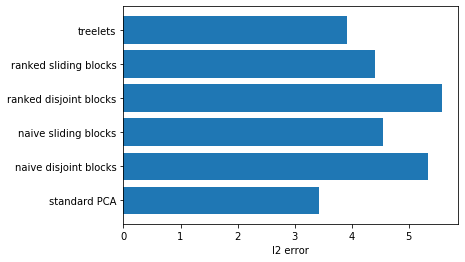

In [3]:
error = [0]*6 
runs = 3

for i in tqdm(range(runs)):
    n,T,q = (20, 500,3)
    random_matrix = np.random.random((n,q))
    loadings = np.sqrt(n)*np.linalg.qr(random_matrix)[0]
    var_cov = scipy.linalg.toeplitz([0.9**r for r in range(q)]) + 10*np.diag(np.random.random(q))

    (panel, 
     factors, 
     common_component, 
     ideosyncratic_component) = sim.static.no_serial_correlation(loadings, var_cov, 1, T)

    x = recover.evaluate_blocking_schemes(loadings,factors,common_component,ideosyncratic_component,
                                          n_factors = q,
                                          block_size = 2)
    
    error = [error[i] + x.compare_loadings_to_population()[i]/runs for i in range(6)]
    
plt.barh(x.blocking_schemes,error)
plt.xlabel("l2 error")

#### Which averaging scheme best approximates PCA? 

Treelets and sliding blocks are closest to the PCA estimator;  disjoint blocks are furthest, although this is unsurprising as they are sparese in the $l_0$ sense while the PCA estimatr is dense. 

100%|██████████| 100/100 [02:24<00:00,  1.45s/it]


Text(0.5, 0, 'l2 error')

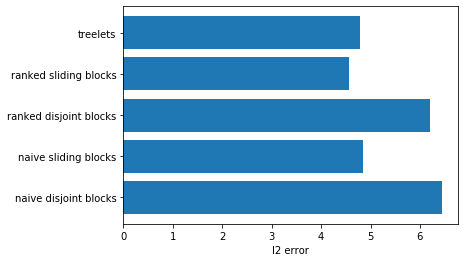

In [10]:
error = [0]*5
runs = 100

for i in tqdm(range(runs)):
    n,T,q = (20, 500,3)
    random_matrix = np.random.random((n,q))
    loadings = np.sqrt(n)*np.linalg.qr(random_matrix)[0]
    var_cov = scipy.linalg.toeplitz([0.9**r for r in range(q)]) + 10*np.diag(np.random.random(q))

    (panel, 
     factors, 
     common_component, 
     ideosyncratic_component) = sim.static.no_serial_correlation(loadings, var_cov, 1, T)

    x = recover.evaluate_blocking_schemes(loadings,factors,common_component,ideosyncratic_component,
                                          n_factors = q,
                                          block_size = 2)
    
    error = [error[i] + x.compare_loadings_to_PCA()[i]/runs for i in range(5)]
    
plt.barh(x.blocking_schemes[1:],error)
plt.xlabel("l2 error")

### Impack of Block Size

In [16]:
block_errors = []

for block_size in range(2,10): 
    
    error = [0]*5
    runs = 20

    for i in tqdm(range(runs)):
        n,T,q = (20, 500,3)
        random_matrix = np.random.random((n,q))
        loadings = np.sqrt(n)*np.linalg.qr(random_matrix)[0]
        var_cov = scipy.linalg.toeplitz([0.9**r for r in range(q)]) + 10*np.diag(np.random.random(q))

        (panel, 
         factors, 
         common_component, 
         ideosyncratic_component) = sim.static.no_serial_correlation(loadings, var_cov, 1, T)

        x = recover.evaluate_blocking_schemes(loadings,factors,common_component,ideosyncratic_component,
                                              n_factors = q,
                                              block_size = 2)

        error = [error[i] + x.compare_loadings_to_PCA()[i]/runs for i in range(5)]
    
    block_errors += error

100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


### Impact of Panel Size ($n$)

#### Do blocking schemes approach population loadings?

The following simulations have $q = 3$ common factors and all blocking schemes process variables in blocks of $3$. All estimators show the desired "blessing of dimensionality" as $n \rightarrow \infty$; PCA and treelets consistently achieve the lowest normalized distance from the true loadings. 

100%|██████████| 46/46 [02:36<00:00,  3.41s/it]


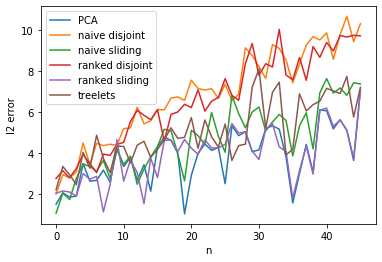

In [7]:
standard_PCA_error = []
naive_disjoint_blocks_error = []
naive_sliding_blocks_error = []
ranked_disjoint_blocks_error = []
ranked_sliding_blocks_error = []
treelets_error = [] 

for n in tqdm(np.arange(4,50)): 
    
    T,q = (500,3)
    random_matrix = np.random.random((n,q))
    loadings = np.sqrt(n)*np.linalg.qr(random_matrix)[0]
    var_cov = scipy.linalg.toeplitz([0.9**r for r in range(q)]) + 10*np.diag(np.random.random(q))
    panel = sim.static.no_serial_correlation(loadings, var_cov, 1, T)[0]
    
    
    
    standard_PCA_error += [matrix_error(loadings,estimate.standard_PCA(panel,q)[0])]
    naive_disjoint_blocks_error += [matrix_error(loadings,estimate.naive_disjoint_blocks(panel,3,q)[0])]
    naive_sliding_blocks_error += [matrix_error(loadings,estimate.naive_sliding_blocks(panel,3,q)[0])]
    ranked_disjoint_blocks_error += [matrix_error(loadings,estimate.ranked_disjoint_blocks(panel,3,q)[0])]
    ranked_sliding_blocks_error += [matrix_error(loadings,estimate.ranked_sliding_blocks(panel,3,q)[0])]
    treelets_error += [matrix_error(loadings,estimate.from_treelets(panel,q)[0])]
    
plt.plot(standard_PCA_error, label = "PCA")
plt.plot(naive_disjoint_blocks_error, label = "naive disjoint")
plt.plot(naive_sliding_blocks_error, label = "naive sliding")
plt.plot(ranked_disjoint_blocks_error, label = "ranked disjoint")
plt.plot(ranked_sliding_blocks_error, label = "ranked sliding")
plt.plot(treelets_error, label = "treelets")

plt.xlabel("n")
plt.ylabel("l2 error")
plt.legend()

#### Do blocking schemes approach PCA results?

The simulation is as above; this time the distance from the PCA estimate is considered. All distances decrease, which is not surprising since all blocking schemes are converging to the same object by the above result. Treelets and the two sliding schemes are closest to the PCA estimator. This again is not surprising since two

100%|██████████| 46/46 [02:45<00:00,  3.60s/it]


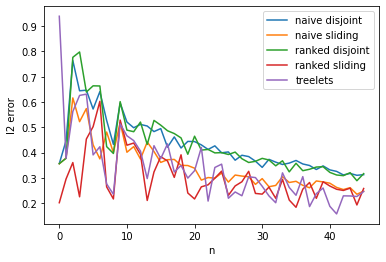

In [245]:
naive_disjoint_blocks_error = []
naive_sliding_blocks_error = []
ranked_disjoint_blocks_error = []
ranked_sliding_blocks_error = []
treelets_error = [] 

for n in tqdm(np.arange(4,50)): 
    
    T,q = (500,3)
    random_matrix = np.random.random((n,q))
    loadings = np.sqrt(n)*np.linalg.qr(random_matrix)[0]
    var_cov = scipy.linalg.toeplitz([0.9**r for r in range(q)]) + 10*np.diag(np.random.random(q))
    panel = sim.static.no_serial_correlation(loadings, var_cov, 1, T)[0]
    
    PCA = np.abs(estimate.standard_PCA(panel,q)[0])
    naive_disjoint_blocks_error += [matrix_error(PCA,estimate.naive_disjoint_blocks(panel,3,q)[0])]
    naive_sliding_blocks_error += [matrix_error(PCA,estimate.naive_sliding_blocks(panel,3,q)[0])]
    ranked_disjoint_blocks_error += [matrix_error(PCA,estimate.ranked_disjoint_blocks(panel,3,q)[0])]
    ranked_sliding_blocks_error += [matrix_error(PCA,estimate.ranked_sliding_blocks(panel,3,q)[0])]
    treelets_error += [matrix_error(PCA,estimate.from_treelets(panel,q)[0])]
    
plt.plot(naive_disjoint_blocks_error, label = "naive disjoint")
plt.plot(naive_sliding_blocks_error, label = "naive sliding")
plt.plot(ranked_disjoint_blocks_error, label = "ranked disjoint")
plt.plot(ranked_sliding_blocks_error, label = "ranked sliding")
plt.plot(treelets_error, label = "treelets")

plt.xlabel("n")
plt.ylabel("l2 error")
plt.legend()

## Recovering local Structures

### General Comparison

#### Recovering very sparse loadings (density = 0.2)

PCA, treelets, and sliding schemes seem to perform equally well. PCA performs surprisingly well, althouh the estimator is dense. The performance of treelets is surprising, as they are designed to pick out local structures. 

In [34]:
error = [0]*6 
runs = 100

for i in tqdm(range(runs)):
    n,T,q = (10, 500,3)
    random_matrix = random(n,q,0.05).A
    loadings = np.sqrt(n)*np.linalg.qr(random_matrix)[0]
    var_cov = scipy.linalg.toeplitz([0.9**r for r in range(q)]) + 10*np.diag(np.random.random(q))

    (panel, 
     factors, 
     common_component, 
     ideosyncratic_component) = sim.static.no_serial_correlation(loadings, var_cov, 1, T)

    x = recover.evaluate_blocking_schemes(loadings,factors,common_component,ideosyncratic_component,
                                          n_factors = q,
                                          block_size = 1)
    
    error = [error[i] + x.compare_loadings_to_population()[i]/runs for i in range(6)]
    
plt.barh(x.blocking_schemes,error)
plt.xlabel("l2 error")

  7%|▋         | 7/100 [00:02<00:36,  2.52it/s]


KeyboardInterrupt: 

In [112]:

n,T,q = (30, 500,2)
random_matrix = random(n,q,0.3).A
loadings = np.sqrt(n)*np.linalg.qr(random_matrix)[0]
var_cov = scipy.linalg.toeplitz([0.9**r for r in range(q)]) + 10*np.diag(np.random.random(q))

(panel, 
 factors, 
 common_component, 
 ideosyncratic_component) = sim.static.no_serial_correlation(loadings, var_cov, 1, T)

x = recover.evaluate_blocking_schemes(loadings,factors,common_component,ideosyncratic_component,
                                      n_factors = q,
                                      block_size = 3)

In [110]:
loadings

array([[ 0.00000000e+00, -2.41369801e-16],
       [-2.18071366e+00, -6.10710089e-03],
       [-0.00000000e+00,  0.00000000e+00],
       [-2.19462958e+00, -6.14607251e-03],
       [-6.32641625e-01, -1.77171643e-03],
       [-0.00000000e+00,  0.00000000e+00],
       [-0.00000000e+00,  3.15783486e+00],
       [-1.66893666e-01,  1.67334406e-01],
       [-0.00000000e+00,  0.00000000e+00],
       [-0.00000000e+00,  0.00000000e+00]])

In [111]:
x.standard_PCA.est_loadings 

array([[ 0.02066048, -0.01704397],
       [-0.57115752, -2.12551989],
       [-0.00673689,  0.01983838],
       [-0.59616822, -2.0851539 ],
       [-0.17881588, -0.62802381],
       [ 0.01294599, -0.003808  ],
       [ 3.04557993, -0.83754437],
       [ 0.09878774, -0.19049048],
       [-0.00825149, -0.0239577 ],
       [ 0.01906236,  0.02906507]])

In [106]:
x.ranked_disjoint_blocks.est_loadings

array([[ 0.        ,  0.        ],
       [ 2.49890294, -1.93787693],
       [-1.93762285, -2.49879986],
       [ 0.        ,  0.        ],
       [ 0.0331933 ,  0.02514553],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

In [107]:
x.from_treelets.est_loadings

array([[ 0.00833743,  0.        ],
       [ 2.49925153,  1.93731503],
       [-1.93722938,  2.49936202],
       [ 0.00819787,  0.        ],
       [ 0.00899448,  0.        ],
       [-0.00885512,  0.        ],
       [ 0.00519157,  0.        ],
       [ 0.00904526,  0.        ],
       [-0.02085956,  0.        ],
       [-0.00664875,  0.        ]])

#### Recovering somewhat dense loadings (density = 0.5)

As the density of the matrix approaches 1 the relative performance of the blocking schemes approaches the standard setting of dense loadings.

100%|██████████| 100/100 [02:24<00:00,  1.45s/it]


Text(0.5, 0, 'l2 error')

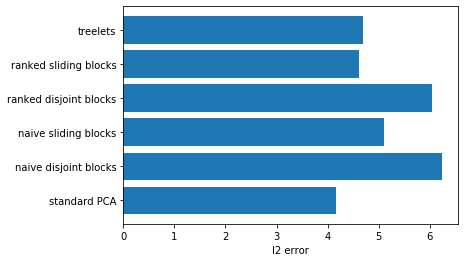

In [14]:
error = [0]*6 
runs = 100

for i in tqdm(range(runs)):
    n,T,q = (20, 500,3)
    random_matrix = random(n,q,0.5).A
    loadings = np.sqrt(n)*np.linalg.qr(random_matrix)[0]
    var_cov = scipy.linalg.toeplitz([0.9**r for r in range(q)]) + 10*np.diag(np.random.random(q))

    (panel, 
     factors, 
     common_component, 
     ideosyncratic_component) = sim.static.no_serial_correlation(loadings, var_cov, 1, T)

    x = recover.evaluate_blocking_schemes(loadings,factors,common_component,ideosyncratic_component,
                                          n_factors = q,
                                          block_size = 2)
    
    error = [error[i] + x.compare_loadings_to_population()[i]/runs for i in range(6)]
    
plt.barh(x.blocking_schemes,error)
plt.xlabel("l2 error")